# Imports

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import plotly.express as px

import seaborn as sns
from matplotlib import pyplot as plt

from scipy.cluster.hierarchy import dendrogram
from scipy import stats
from sklearn.cluster import AgglomerativeClustering
from libpysal.weights import Queen, KNN
from esda.moran import Moran
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import robust_scale
import urllib.request
import gzip

# Magic to reload notebook
%load_ext autoreload
%autoreload 2
pd.options.display.max_columns = 100

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
df_mun_malha = gpd.read_file('../data/raw/ibge/BR_Municipios_2020.shp')

In [3]:
df_cidades = pd.ExcelFile('../data/raw/ibge/IBGE_CIDADES_5564.xls')

In [4]:
df_mun_infos = df_cidades.parse('Síntese das Informações')

In [5]:
df_mun_coord = pd.read_csv('../data/raw/municipios_coords.csv')

In [6]:
df_mun_idh = pd.read_excel('../data/raw/atlas/Atlas 2013_municipal, estadual e Brasil.xlsx', sheet_name='MUN 91-00-10')

In [7]:
df_qtde_sus = pd.read_csv('../data/raw/datasus/cadastro_estabelecimentos_cnes.csv')

In [8]:
dados_covid = pd.read_parquet('../data/processed/covid_saude.parquet')
dados_covid['data'] = pd.to_datetime(dados_covid['data'])

# Data processing

**Dados COVID**  
```
dados_covid_brasil  
dados_covid_estados  
dados_covid_cidades 
```

In [9]:
dados_covid.sort_values(by=['data'], inplace=True)

In [10]:
dados_covid['year'] = dados_covid['data'].dt.year
dados_covid['weekday'] = dados_covid['data'].dt.weekday
dados_covid['week_number'] = 0
dados_covid.loc[dados_covid['weekday']==0, 'week_number'] = 1

In [11]:
dados_covid_cidades = dados_covid.loc[dados_covid['regiao']!='Brasil']
dados_covid_cidades = dados_covid_cidades[dados_covid_cidades['municipio'].notna()]
dados_covid_cidades.reset_index(drop=True, inplace=True)

In [12]:
dados_covid_estados = dados_covid.loc[dados_covid['regiao']!='Brasil']
dados_covid_estados = dados_covid_estados[dados_covid_estados['municipio'].isna()]
dados_covid_estados.reset_index(drop=True, inplace=True)

In [13]:
dados_covid_brasil = dados_covid.loc[dados_covid['regiao']=='Brasil']
dados_covid_brasil.reset_index(drop=True, inplace=True)

In [14]:
dados_covid_cidades['week_number'] = dados_covid_cidades.groupby('codmun')['week_number'].cumsum()
dados_covid_estados['week_number'] = dados_covid_estados.groupby('estado')['week_number'].cumsum()
dados_covid_brasil['week_number'] = dados_covid_brasil['week_number'].cumsum()

In [15]:
df_mun_idh = df_mun_idh.loc[df_mun_idh['ANO']==2010]

In [16]:
df_mun_infos.rename(columns={'Código IBGE do Município':'codigo_ibge_2'}, inplace=True)
df_mun_idh.rename(columns={'Codmun6':'codigo_ibge_2', 
                           'Codmun7':'codigo_ibge_1'}, inplace=True)
df_mun_malha.rename(columns={'CD_MUN':'codigo_ibge_1'}, inplace=True)
df_mun_coord.rename(columns={'codigo_ibge':'codigo_ibge_1'}, inplace=True)

In [17]:
df_mun_malha['codigo_ibge_1'] = df_mun_malha['codigo_ibge_1'].astype(int)

In [18]:
df_mun_infos = df_mun_infos.merge(df_mun_idh[['codigo_ibge_2','codigo_ibge_1', 'Município']], how='left', on='codigo_ibge_2')

In [19]:
df_mun_infos = df_mun_malha[['codigo_ibge_1', 'AREA_KM2', 'geometry']].merge(df_mun_infos, how='left', on='codigo_ibge_1')

In [20]:
# df_mun_infos['Nome da Microregião'] = df_mun_infos['Nome da Microregião'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
# df_mun_coord['nome'] = df_mun_coord['nome'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [21]:
R = 6371 # The approximate radius of Earth (in Km)

df_mun_coord['coord_x'] = R * np.cos(df_mun_coord['latitude']) * np.cos(df_mun_coord['longitude'])
df_mun_coord['coord_y'] = R * np.cos(df_mun_coord['latitude']) * np.sin(df_mun_coord['longitude'])
df_mun_coord['coord_z'] = R * np.sin(df_mun_coord['latitude'])

In [22]:
df_mun_infos = df_mun_infos.merge(df_mun_coord[['codigo_ibge_1', 'coord_x', 'coord_y', 'coord_z']], how='left', on='codigo_ibge_1')

In [23]:
df_features = df_mun_infos[['codigo_ibge_1',
                            'Município',
                            'geometry',
                            'Estabelecimentos de Saúde SUS',
                            'AREA_KM2',
                            'Índice de Desenvolvimento Humano Municipal - 2010 (IDHM 2010)',
                            'PIB per capita a preços correntes',
                            'População residente',
                            'coord_x', 
                            'coord_y', 
                            'coord_z']]

# Reduzir número de variáveis (variáveis correlacionadas) <- olhar multicolinearidade
# Clima
# Altitude
# Considerar características que mudam ao longo do tempo e têm relação com a doença (estações do ano influenciam)

In [ ]:
# df_features = df_features.merge(df_mun_coord[['codigo_ibge', 'nome', 'latitude', 'longitude']], how='left', left_on='Nome da Microregião', right_on='nome')

# Checking missing data in cities

We have to define what are the cities with missing data. A city can have only 1 ou 2 deaths accumulated in 2 years or is this indicative of missing data? Let's check this now!

In [ ]:
print('Number of cities with covid data =', dados_covid_cidades['codmun'].nunique())

It seems that our covid dataset has all Brazilian cities (5570). Let's check the number of deaths accumulated in each city until today.

In [ ]:
df_cities_last_date = dados_covid_cidades.drop_duplicates(subset=['codmun'], keep='last').sort_values(by=['obitosAcumulado'], ascending=True)

In [ ]:
df_cities_last_date[['obitosAcumulado']].describe()

Some metropolitan cities had an exuberant number of deaths, let's remove the outliers to not impact our analysis.

In [ ]:
df_cities_last_date_no_outlier = df_cities_last_date[(np.abs(stats.zscore(df_cities_last_date[['obitosAcumulado']])) < 3).all(axis=1)]

In [ ]:
df_cities_last_date_no_outlier[['obitosAcumulado']].describe()

In [ ]:
df_cities_last_date_no_outlier[['obitosAcumulado']].hist()

We can see that almost half of the cities had less than 20 deaths registered until the 6th october 2021. To check if this is a low number or an indication of missing data, let's compare it with the population size in each city.

In [ ]:
df_cities_last_date_no_outlier = df_cities_last_date_no_outlier.merge(
    df_mun_infos[['codigo_ibge_2', 'População residente']],
    how='left',
    left_on='codmun',
    right_on='codigo_ibge_2')

In [ ]:
df_cities_last_date_no_outlier['deaths/population'] = df_cities_last_date_no_outlier['obitosAcumulado']/df_cities_last_date_no_outlier['População residente']

In [ ]:
df_cities_last_date_no_outlier[['deaths/population']].describe()

Let's check for negative data

In [ ]:
dados_covid_cidades['obitosNovos'].describe()

In [ ]:
dados_covid_cidades.loc[dados_covid_cidades['obitosNovos']<0, 'codmun'].nunique()

# Modeling

Seguiremos a seguir o desenvolvimento de clusterização descrito em: [geographicdata.science](https://geographicdata.science/book/notebooks/10_clustering_and_regionalization.html#introduction)

In [24]:
cluster_variables = ['Estabelecimentos de Saúde SUS',
                     'AREA_KM2',
                     'Índice de Desenvolvimento Humano Municipal - 2010 (IDHM 2010)',
                     'PIB per capita a preços correntes',
                     'coord_x',
                     'coord_y',
                     'coord_z'
#                      'População residente'
                    ]

In [25]:
df_mun_infos = gpd.GeoDataFrame(df_mun_infos)

In [26]:
df_mun_infos[cluster_variables] = df_mun_infos[cluster_variables].fillna(df_mun_infos[cluster_variables].median())

Spatial distribution of each variable alone

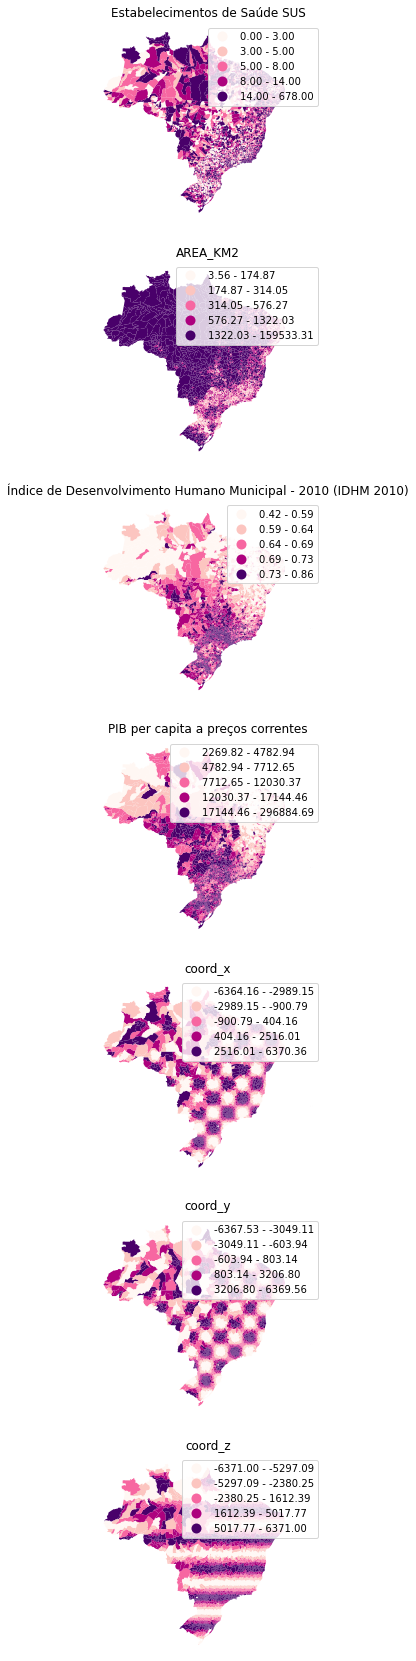

In [28]:
f, axs = plt.subplots(nrows=len(cluster_variables), ncols=1, figsize=(30, 30))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    df_mun_infos.plot(
        column=col, 
        ax=ax,
        scheme='Quantiles', 
        linewidth=0,
        cmap='RdPu',
        legend=True
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

Podemos observar que:
- A **quantidade de estabelecimentos de saúde SUS** e a **população residente** em cada município são bem distribuídas ao longo de todo território brasileiro
- Os maiores **IDHs** se concentram nas regiões centro-oeste, sudeste e sul
- Os municípios de maior **área** se concentram nas regiões norte, centro-oeste e interior do nordeste
- Os municípios de maior **PIB** se concentram nas regiões centro-oeste, sudeste e sul

"Now let’s calculate Moran’s I for the variables being used. This will measure the extent to which each variable contains spatial structure:"

In [ ]:
# # Set seed for reproducibility
# np.random.seed(42)
# # Calculate Moran's I for each variable
# mi_results = [Moran(df_mun_infos[variable], w) for variable in cluster_variables]
# # Structure results as a list of tuples
# mi_results = [
#     (variable, res.I, res.p_sim) for variable,res in zip(cluster_variables, mi_results)
# ]
# # Display on table
# table = pd.DataFrame(
#     mi_results,
#     columns=['Variable', "Moran's I", 'P-value']
# ).set_index('Variable')
# table

"Each of the variables displays significant positive spatial autocorrelation, suggesting clear spatial structure in the socioeconomic geography of Brazil. This means it is likely the clusters we find will have a non random spatial distribution."

"To explore cross-attribute relationships, we need to consider the spatial correlation between variables."

In [ ]:
_ = sns.pairplot(df_mun_infos[cluster_variables], kind='reg', diag_kind='kde')

In [ ]:
df_mun_infos[cluster_variables].corr()

Analisando as distribuições univariadas dos valores de cada variável, observam-se algumas variáveis assimétricas positivas (estabelecimentos SUS, área, PIB e população), enquanto o IDH se demonstra centralizado com 2 picos.

In [27]:
drop_columns = ['Município', 'geometry', 'codigo_ibge_1', 'codigo_ibge_2']

In [28]:
df = df_mun_infos[cluster_variables+drop_columns]

"A clustering algorithm that uses distance to determine classifications may be affected by outliers. Therefore, as a rule, we standardize our data when clustering."

In [29]:
df[cluster_variables] = robust_scale(df[cluster_variables])

In [30]:
scaler = MinMaxScaler()

In [31]:
scaler.fit(df[cluster_variables])

MinMaxScaler()

In [32]:
df[cluster_variables] = scaler.transform(df[cluster_variables])

In [ ]:
df.describe()

In [35]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

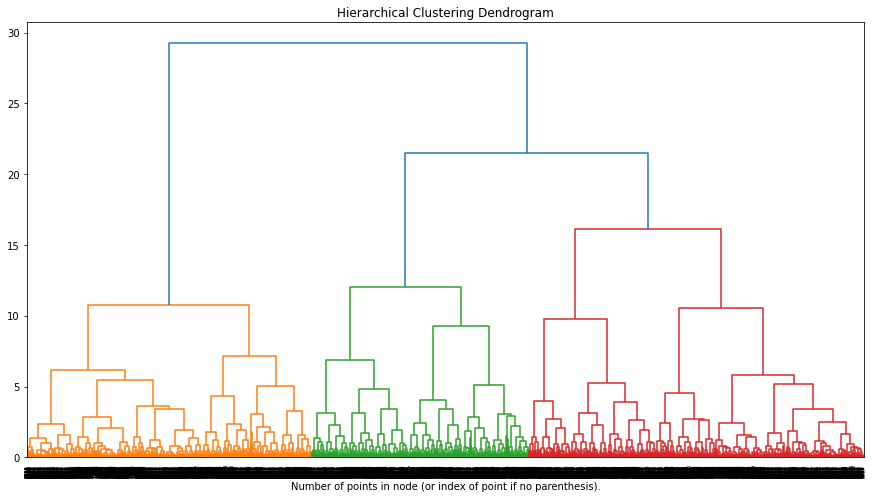

In [37]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df.drop(columns=drop_columns))
plt.figure(figsize=(15,8))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=50)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

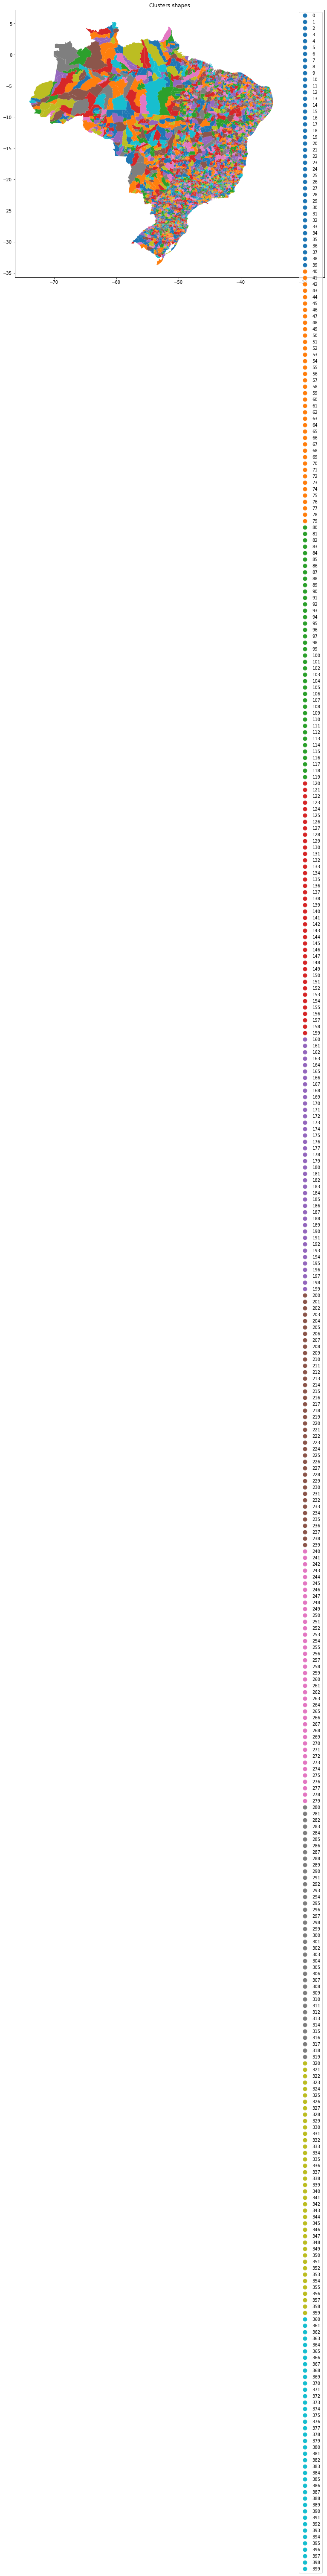

In [38]:
# Set the seed for reproducibility
np.random.seed(42)
# Specify cluster model with spatial constraint
model = AgglomerativeClustering(
    linkage='ward', n_clusters=400
)
# Fit algorithm to the data
model.fit(df.drop(columns=drop_columns))

# Assign labels to main data table
df['cluster'] = model.labels_

# Euclidian, average
df[['geometry', 'cluster']].plot(column='cluster', figsize=(13,13), categorical=True, legend=True)
plt.title('Clusters shapes')
plt.show()

In [ ]:
df_mun_infos.loc[df_mun_infos.index.isin([3242,3829,949,2309,2162,5569,111,4005,3479,5417,1596])]

Pelo dendrograma observa-se que logo na primeira divisão já são separadas 2 cidades (3242 SP e 3829 RJ) das 5568 demais. Vamos tentar remover as capitais e plotar o dendrograma novamente.

In [ ]:
df_no_capitals = df.loc[~df['codigo_ibge_1'].isin([1100205,1302603,1200401,5002704,1600303,5300108,1400100,5103403,1721000,3550308,2211001,3304557,1501402,5208707,4205407,2111300,2704302,4314902,4106902,3106200,2304400,2611606,2507507,2800308,2408102,3205309])]

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df_no_capitals.drop(columns=drop_columns))
plt.figure(figsize=(15,8))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Já temos clusters melhores dividos e não tão influenciados pelas capitais. Vamos testar agora removendo os outliers do dataset completo

In [ ]:
df_no_outlier = df[(np.abs(stats.zscore(df[cluster_variables])) < 3).all(axis=1)]

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df_no_outlier.drop(columns=drop_columns))
plt.figure(figsize=(15,8))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Removendo os outliers a quantidade de municípios em cada cluster é muito mais balanceada. Vamos continuar a clusterização com o dataset sem outlier e depois definiremos o cluster das demais 207 cidades

In [ ]:
# Suppose 15 clusters (5 features classified as low, medium or high)
model = AgglomerativeClustering(linkage='ward', n_clusters=15)

model = model.fit(df_no_outlier.drop(columns=drop_columns))

# Assign labels to main data table
df_no_outlier['cluster'] = model.labels_

# Euclidian, average
df_no_outlier[['geometry', 'cluster']].plot(column='cluster', figsize=(13,13), categorical=True, legend=True)
plt.title('Clusters shapes')
plt.show()

In [ ]:
cluster_means = df_no_outlier.groupby('cluster')[cluster_variables].mean()
cluster_means.T.round(3)

In [ ]:
# Index db on cluster ID
tidy_df = df_no_outlier.set_index('cluster')
# Keep only variables used for clustering
tidy_df = tidy_df[cluster_variables]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_df = tidy_df.stack()
# Take indices into proper columns
tidy_df = tidy_df.reset_index()
# Rename column names
tidy_df = tidy_df.rename(
    columns={'level_1': 'Attribute', 0: 'Values'}
)
# Check out result
tidy_df.head()

In [ ]:
# Setup the facets
facets = sns.FacetGrid(
    data=tidy_df,
    col='Attribute',
    hue='cluster', 
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3
)
# Build the plot as a `sns.kdeplot`
facets.map(sns.kdeplot, 'Values', shade=True).add_legend();

## Regionalisation: Spatially Constrained Hierarchical Clustering

### Contiguity constraint

"Moran’s I is a commonly used measure for global spatial autocorrelation. We can use it to formalise some of the intuitions built from the maps. We will need to represent the spatial configuration of the data points through a spatial weights matrix. We will start with queen contiguity:"

In [ ]:
w = Queen.from_dataframe(df_no_outlier)

In [ ]:
# Set the seed for reproducibility
np.random.seed(42)
# Specify cluster model with spatial constraint
model = AgglomerativeClustering(
    linkage='ward', connectivity=w.sparse, n_clusters=15
)
# Fit algorithm to the data
model.fit(df_no_outlier.drop(columns=drop_columns))

# Assign labels to main data table
df_no_outlier['cluster'] = model.labels_

# Euclidian, average
df_no_outlier[['geometry', 'cluster']].plot(column='cluster', figsize=(13,13), categorical=True, legend=True)
plt.title('Clusters shapes')
plt.show()

### Changing the spatial constraint

In [ ]:
df_no_outlier.drop(columns=drop_columns)

In [33]:
df_geometry = df[['Estabelecimentos de Saúde SUS',
                  'AREA_KM2',
                  'Índice de Desenvolvimento Humano Municipal - 2010 (IDHM 2010)',
                  'PIB per capita a preços correntes',
#                           'População residente',
                  'geometry']]

In [39]:
w_knn = KNN.from_dataframe(df_geometry, k=15)

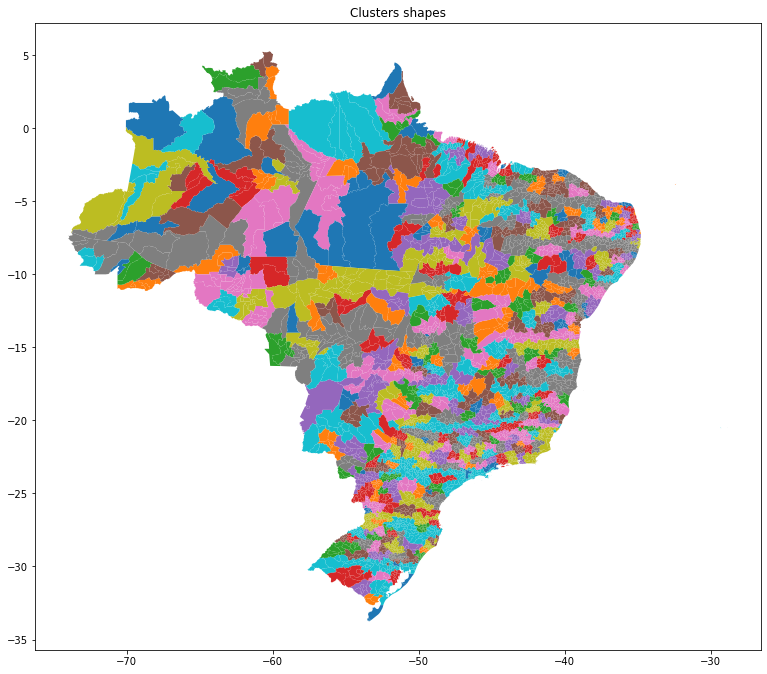

In [40]:
# Set the seed for reproducibility
np.random.seed(42)
# Specify cluster model with spatial constraint
model = AgglomerativeClustering(
    linkage='ward', connectivity=w_knn.sparse, n_clusters=500
)
# Fit algorithm to the data
model.fit(df.drop(columns=drop_columns))

# Assign labels to main data table
df['cluster'] = model.labels_

# Euclidian, average
df[['geometry', 'cluster']].plot(column='cluster', figsize=(13,13), categorical=True)
plt.title('Clusters shapes')
plt.show()

In [37]:
cluster_size = df.groupby('cluster').size()

In [38]:
cluster_size.describe()

count    500.000000
mean      11.140000
std       10.566158
min        1.000000
25%        5.000000
50%        9.000000
75%       14.000000
max      101.000000
dtype: float64

In [ ]:
cluster_size.hist()

In [ ]:
cluster_size.plot.box()

In [ ]:
cluster_size

In [ ]:
cluster_size = df_no_outlier.groupby('cluster').size()
cluster_size

# Plot Clusters

In [48]:
codigo_uf = [11,12,13,14,15,16,17,21,22,23,24,25,26,27,28,29,31,32,33,35,41,42,43,50,51,52,53]
unidade_uf = ['Rondônia','Acre','Amazonas','Roraima','Pará','Amapá','Tocantins','Maranhão','Piauí','Ceará','Rio Grande do Norte','Paraíba','Pernambuco','Alagoas','Sergipe','Bahia','Minas Gerais','Espírito Santo','Rio de Janeiro','São Paulo','Paraná','Santa Catarina','Rio Grande do Sul','Mato Grosso do Sul','Mato Grosso','Goiás','Distrito Federal']
uf = ['RO','AC','AM','RR','PA','AP','TO','MA','PI','CE','RN','PB','PE','AL','SE','BA','MG','ES','RJ','SP','PR','SC','RS','MS','MT','GO','DF']

df_codigo_uf = pd.DataFrame(
    {'codigo_uf': codigo_uf,
     'unidade_da_federacao': unidade_uf,
     'uf': uf
    })

In [50]:
import time

In [51]:
i = 0
json_cities_shape = {'type': 'FeatureCollection', 'features':[]}
for cod_ibge in tqdm(df_codigo_uf['codigo_uf'].unique()):
    with urllib.request.urlopen(f"https://servicodados.ibge.gov.br/api/v2/malhas/{cod_ibge}?resolucao=5&formato=application/vnd.geo+json") as url:
        time.sleep(0.5)
        try:
            s = gzip.decompress(url.read())
        except Exception as e:
            s = url.read()
        time.sleep(0.5)
        try:
            json_city = json.loads(s)
            json_cities_shape['features'].extend(json_city['features'])
        except Exception as e:
            print(cod_ibge)
            print(s)
        time.sleep(0.5)

 15%|█▍        | 4/27 [00:08<00:50,  2.20s/it]

15
b''


 33%|███▎      | 9/27 [00:18<00:35,  1.96s/it]

23
b''


 41%|████      | 11/27 [00:23<00:36,  2.28s/it]

25
b''


 59%|█████▉    | 16/27 [00:33<00:21,  1.98s/it]

31
b''


 67%|██████▋   | 18/27 [00:38<00:19,  2.14s/it]

33
b''


 78%|███████▊  | 21/27 [00:45<00:13,  2.32s/it]

42
b''


 81%|████████▏ | 22/27 [00:48<00:13,  2.65s/it]

43
b''


 89%|████████▉ | 24/27 [00:53<00:07,  2.36s/it]

51
b''


100%|██████████| 27/27 [01:02<00:00,  2.33s/it]


In [41]:
df['codarea'] = df['codigo_ibge_1']
df['codarea'] = df['codarea'].astype(str)
df['cluster'] = df['cluster'].astype(str)

In [42]:
json_file = open('../data/app/cities_shape.json')

In [43]:
json_cities_shape = json.load(json_file)

In [44]:
for idx, city in enumerate(json_cities_shape['features']):
    cluster = df.loc[df['codarea']==city['properties']['codarea'], 'cluster'].iloc[0]
    json_cities_shape['features'][idx]['properties']['cluster'] = cluster

In [45]:
cluster = '351'

In [46]:
# Filter python objects with list comprehensions
cities_filtered_list = [x for x in json_cities_shape['features'] if x['properties']['cluster'] == cluster]
dict_shape_cities_plot = {'type': 'FeatureCollection', 'features':cities_filtered_list}
# # Transform python object back into json
# output_json = json.dumps(output_dict)

In [47]:
fig = px.choropleth_mapbox(
    df.loc[df['cluster']==cluster], # banco de dados da soja
    locations="codarea", # definindo os limites no mapa
    featureidkey="properties.codarea",
    geojson=dict_shape_cities_plot, # definindo as delimitações geográficas
#     color="cluster", # definindo a cor através da base de dados
    hover_name="Município", # pontos que você quer mostrar na caixinha de informação
    hover_data=[ 'Município',  'cluster'],
    title='Indice de Letalitade por Região',
    mapbox_style="carto-positron", # Definindo novo estilo de mapa, o de satélite
    zoom=3,  # o tamanho do gráfico
    opacity=0.5, # opacidade da cor do map
    center={"lat": -14, "lon": -55},
    width=1000, height=900,)

fig.show()

# Save data

In [51]:
df.rename(columns={'Estabelecimentos de Saúde SUS': 'Estabelecimentos de Saúde SUS scaled', 
'AREA_KM2': 'AREA_KM2 scaled', 
'Índice de Desenvolvimento Humano Municipal - 2010 (IDHM 2010)': 'Índice de Desenvolvimento Humano Municipal - 2010 (IDHM 2010) scaled', 
'PIB per capita a preços correntes': 'PIB per capita a preços correntes scaled'}, inplace=True) 
            
df = df.merge(df_mun_infos[['codigo_ibge_2', 
              'Estabelecimentos de Saúde SUS', 
              'AREA_KM2', 
              'Índice de Desenvolvimento Humano Municipal - 2010 (IDHM 2010)', 
              'PIB per capita a preços correntes']], how='left', on='codigo_ibge_2')

In [52]:
df[['Estabelecimentos de Saúde SUS', 'AREA_KM2', 'Índice de Desenvolvimento Humano Municipal - 2010 (IDHM 2010)', 'PIB per capita a preços correntes', 'Município', 'codigo_ibge_1', 'codigo_ibge_2', 'cluster', 'codarea']].to_parquet('../data/app/clusters_v4.parquet', index=False)

In [49]:
with open('../data/app/cities_shape_v4.json', 'w') as f:
    json.dump(json_cities_shape, f)

# Verify cluster coherence

In [ ]:
dados_covid = pd.read_parquet('../data/processed/covid_saude.parquet')
dados_covid['data'] = pd.to_datetime(dados_covid['data'])

In [ ]:
dados_covid.sort_values(by=['data'], inplace=True)

In [ ]:
dados_covid['year'] = dados_covid['data'].dt.year
dados_covid['weekday'] = dados_covid['data'].dt.weekday
dados_covid['week_number'] = 0
dados_covid.loc[dados_covid['weekday']==0, 'week_number'] = 1

In [ ]:
dados_covid = dados_covid.merge(df[['codigo_ibge_1', 'cluster']], how='left', left_on='codmun', right_on='codigo_ibge_1')

In [ ]:
dados_covid_cidades = dados_covid.loc[dados_covid['regiao']!='Brasil']
dados_covid_cidades = dados_covid_cidades[dados_covid_cidades['municipio'].notna()]
dados_covid_cidades.reset_index(drop=True, inplace=True)

In [ ]:
dados_covid_estados = dados_covid.loc[dados_covid['regiao']!='Brasil']
dados_covid_estados = dados_covid_estados[dados_covid_estados['municipio'].isna()]
dados_covid_estados.reset_index(drop=True, inplace=True)

In [ ]:
dados_covid_brasil = dados_covid.loc[dados_covid['regiao']=='Brasil']
dados_covid_brasil.reset_index(drop=True, inplace=True)

In [ ]:
dados_covid_cidades['week_number'] = dados_covid_cidades.groupby('codmun')['week_number'].cumsum()
dados_covid_estados['week_number'] = dados_covid_estados.groupby('estado')['week_number'].cumsum()
dados_covid_brasil['week_number'] = dados_covid_brasil['week_number'].cumsum()

In [ ]:
dados_covid_cidades